In [5]:
%cd /content/drive/MyDrive/ML/Project/Cell Chain Model

/content/drive/MyDrive/ML/Project/Cell Chain Model


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import KFold, train_test_split

In [2]:
# Create a class for the dataset
class MatchesDetailsDataset(Dataset):
    def __init__(self, matches_info, matches_details, targets):
        self.matches_info = matches_info
        self.matches_details = matches_details
        self.targets = targets

    def __len__(self):
        return len(self.matches_info)

    def __getitem__(self, idx):
        match_info = self.matches_info.iloc[idx].astype(np.float32).values
        match_details = self.matches_details[self.matches_details['id'] == match_info[0]].astype(np.float32).values
        target = self.targets[self.targets['id'] == match_info[0]].astype(np.float32).values

        # remove id
        return match_info[1:], match_details[:, 2:], target[:, 3:]

In [3]:
matches_info = pd.read_csv('matches_info.csv')
matches_details = pd.read_csv('lstm_x_final.csv')
targets = pd.read_csv('lstm_y_final.csv')

In [4]:
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
# independant cell
class Cell(nn.Module):
    def __init__(self, input_size):
        super(Cell, self).__init__()
        self.input_size = input_size
        self.fc = nn.Sequential(
            nn.Linear(input_size, 1),
            nn.ReLU()
        )
        self.prev_fc = nn.Sequential(
            nn.Linear(input_size, input_size),
            nn.ReLU()
        )
        self.next_fc = nn.Sequential(
            nn.Linear(input_size, input_size),
            nn.ReLU()
        )

    def forward(self, x, h = None):
        if h is None:
            return self.fc(x), self.next_fc(x)
        else:
            updated_features = self.prev_fc(h) + x
            return self.fc(updated_features), self.next_fc(updated_features)

# cell chain
class CellChain(nn.Module):
    def __init__(self, input_size, sequence_length, input_features):
        super(CellChain, self).__init__()
        self.input_size = input_size
        self.number_of_cells = sequence_length
        self.cells = nn.ModuleList()
        self.fc = nn.Sequential(
            nn.Linear(input_features, input_size),
            nn.Tanh()
        )
        self.out1_fc = nn.Sequential(
            nn.Linear(input_size, 1),
            nn.ReLU()
        )
        for _ in range(0, sequence_length):
            self.cells.append(Cell(input_size))

    def forward(self, x, h):
        outputs = []
        bias =  self.fc(h)
        out1 = self.out1_fc(bias)
        outputs.append(out1)
        for i in range(0, self.number_of_cells):
            out, h = self.cells[i](x[:, i, :] + bias, None if i == 0 else h)
            outputs.append(out)

        # return output[0] as single tensor
        result = torch.cat(outputs, dim=1)
        return result, h

class CellChains(nn.Module):
    def __init__(self, input_size, sequence_length, input_features, number_of_chains):
        super(CellChains, self).__init__()
        self.input_size = input_size
        self.number_of_chains = number_of_chains
        self.chains = nn.ModuleList()
        self.fc = nn.Sequential(
            nn.Linear(input_size, input_features),
            nn.Tanh()
        )
        for _ in range(0, self.number_of_chains):
            self.chains.append(CellChain(input_size, sequence_length, input_features))

    def forward(self, x, h0):
        outputs = []
        for i in range(0, self.number_of_chains):
            if i != 0:
                h0 = self.fc(h) + h0
            out, h = self.chains[i](x, h0)
            outputs.append(out)
        return torch.cat(outputs, dim=1)

In [30]:
# train the model
def train_model(model, train_loader, test_loader, optimizer, criterion, epochs):
    for epoch in range(epochs):
        model.train()
        train_losses = []
        test_losses = []

        for x, s, y in train_loader:
            optimizer.zero_grad()

            x = x.to(device)
            s = s.to(device)
            y = y.to(device)

            y_mod_1 = torch.zeros(y[:, :, 2].shape[0], y[:, :, 2].shape[1]//2 + 1).to(device)
            y_mod_2 = torch.zeros(y[:, :, 2].shape[0], y[:, :, 2].shape[1]//2 + 1).to(device)

            y_mod_1[:, 1:] = y[:, :20, 2]
            y_mod_1[:, 0] = y[:, 0, 2]

            y_mod_2[:, 1:] = y[:, 20:, 2]
            y_mod_2[:, 0] = y[:, 20, 2]

            # concatenate the two tensors
            y_mod = torch.cat((y_mod_1, y_mod_2), dim=1)


            # Forward pass
            out = model(s, x)
            train_loss = criterion(out, y_mod)

            # Backward and optimize
            train_loss.backward()
            optimizer.step()

            train_losses.append(train_loss.item())
        
        # evaluate model
        model.eval()
        with torch.no_grad():
            for x, s, y in test_loader:
                x = x.to(device)
                s = s.to(device)
                y = y.to(device)

                y_mod_1 = torch.zeros(y[:, :, 2].shape[0], y[:, :, 2].shape[1]//2 + 1).to(device)
                y_mod_2 = torch.zeros(y[:, :, 2].shape[0], y[:, :, 2].shape[1]//2 + 1).to(device)

                y_mod_1[:, 1:] = y[:, :20, 2]
                y_mod_1[:, 0] = y[:, 0, 2]

                y_mod_2[:, 1:] = y[:, 20:, 2]
                y_mod_2[:, 0] = y[:, 20, 2]

                # concatenate the two tensors
                y_mod = torch.cat((y_mod_1, y_mod_2), dim=1)

                # Forward pass
                out = model(s, x)
                test_loss = criterion(out, y_mod)

                test_losses.append(test_loss.item())
        
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {np.mean(train_losses):.4f}, Test Loss: {np.mean(test_losses):.4f}')


In [12]:
def evaluate_model(model_winner, test, matches_details, targets):
    test_loader = DataLoader(MatchesDetailsDataset(test, matches_details, targets), batch_size=1, shuffle=False)

    # set the model to evaluation
    model_winner.eval()
    with torch.no_grad():
        i = 0
        initial_error = 0
        sanity_error = 0

        total = 0
        for x, s, y in test_loader:
            x = x.to(device)
            s = s.to(device)
            y = y.to(device)

            y_mod = torch.zeros(y[:, :, 1].shape[0], y[:, :, 1].shape[1] + 1).to(device)
            y_mod[:, 1:] = y[:, :, 2]
            y_mod[:, 0] = y[:, 0, 2]

            # Forward pass
            out = model_winner(s, x)

            true_output_1 = y_mod[:, 0].item()

            initial_output = out[:, 0].item()

            

            # minimum index of y_mod with zero value
            zero_index = torch.where(y_mod == 0)[1]
            # check if zero index is not empty
            if zero_index.shape[0] != 0:
                last_pred = (torch.min(zero_index) - 1).item()
            else:
                last_pred = - 1

            sanity_output = out[:, last_pred].item()

            if true_output == 1:
                if initial_output > 0:
                    initial_correct += 1
                if sanity_output > 0:
                    sanity_correct += 1
            else:
                if initial_output < 0:
                    initial_correct += 1
                if sanity_output < 0:
                    sanity_correct += 1

            total += 1
        
        return initial_correct/total * 100, sanity_correct/total * 100
    

In [27]:
input_sequence_features = 18
sequence_length = 20
number_of_features = 30
number_of_chains = 2

In [17]:
# Cross validation
def cross_validation(criterion, epochs, k=5):
    # split the data into k folds
    kf = KFold(n_splits=k, shuffle=True)
    # initialize a numpy array to store the accuracies
    accuracies = []
    # initialize a numpy array to store the accuracies
    accuracies_sanity = []
    # loop over the folds
    train_losses = []
    test_losses = []
    for i, (train_index, test_index) in tqdm(enumerate(kf.split(matches_info))):
        model_winner = CellChain(input_sequence_features, sequence_length, number_of_features)
        optimizer = optim.Adam(model_winner.parameters(), lr=0.001, weight_decay=0.001)

        model_winner.to(device)

        # split the data
        train = matches_info.iloc[train_index]
        test = matches_info.iloc[test_index]
        # create the data loaders
        train_loader = DataLoader(MatchesDetailsDataset(train, matches_details, targets), batch_size=32, shuffle=False)
        test_loader = DataLoader(MatchesDetailsDataset(test, matches_details, targets), batch_size=32, shuffle=False)
        # train the model
        train_loss, test_loss = train_model(model_winner, train_loader, test_loader, optimizer, criterion, epochs)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        torch.save(model_winner.state_dict(), f'cell_chain_winner_model_{i}.pt')

        # evaluate the model
        initial_accuracy, sanity_accuracy = evaluate_model(model_winner, test, matches_details, targets)
        # store the accuracy in the numpy array
        accuracies.append(initial_accuracy)
        accuracies_sanity.append(sanity_accuracy)
    # return the accuracies
    return accuracies, accuracies_sanity, train_losses, test_losses

In [ ]:
criterion = nn.MSELoss()

accuracies, accuracies_sanity, train_losses, test_losses = cross_validation(criterion, 100, k=5)

In [ ]:
# model setup
model_score = CellChains(input_sequence_features, sequence_length, number_of_features, number_of_chains)

criterion = nn.MSELoss()
    
# Optimizer with l2 regularization
optimizer = optim.Adam(model_score.parameters(), lr=0.001, weight_decay=0.001)

model_score.to(device)

In [25]:
train, test = train_test_split(matches_info, test_size=0.2, random_state=42)
train_loader = DataLoader(MatchesDetailsDataset(train, matches_details, targets), batch_size=32, shuffle=False)
test_loader = DataLoader(MatchesDetailsDataset(test, matches_details, targets), batch_size=32, shuffle=False)

In [ ]:
# train the model
train_model(model_score, train_loader, test_loader, optimizer, criterion, 100)

In [32]:
torch.save(model_score.state_dict(), 'cell_chains_score_init_model.pt')

In [10]:
# load the model
model_score.load_state_dict(torch.load('cell_chain_score_init_model.pt'))

<All keys matched successfully>

In [33]:
test_loader = DataLoader(MatchesDetailsDataset(test, matches_details, targets), batch_size=1, shuffle=False)



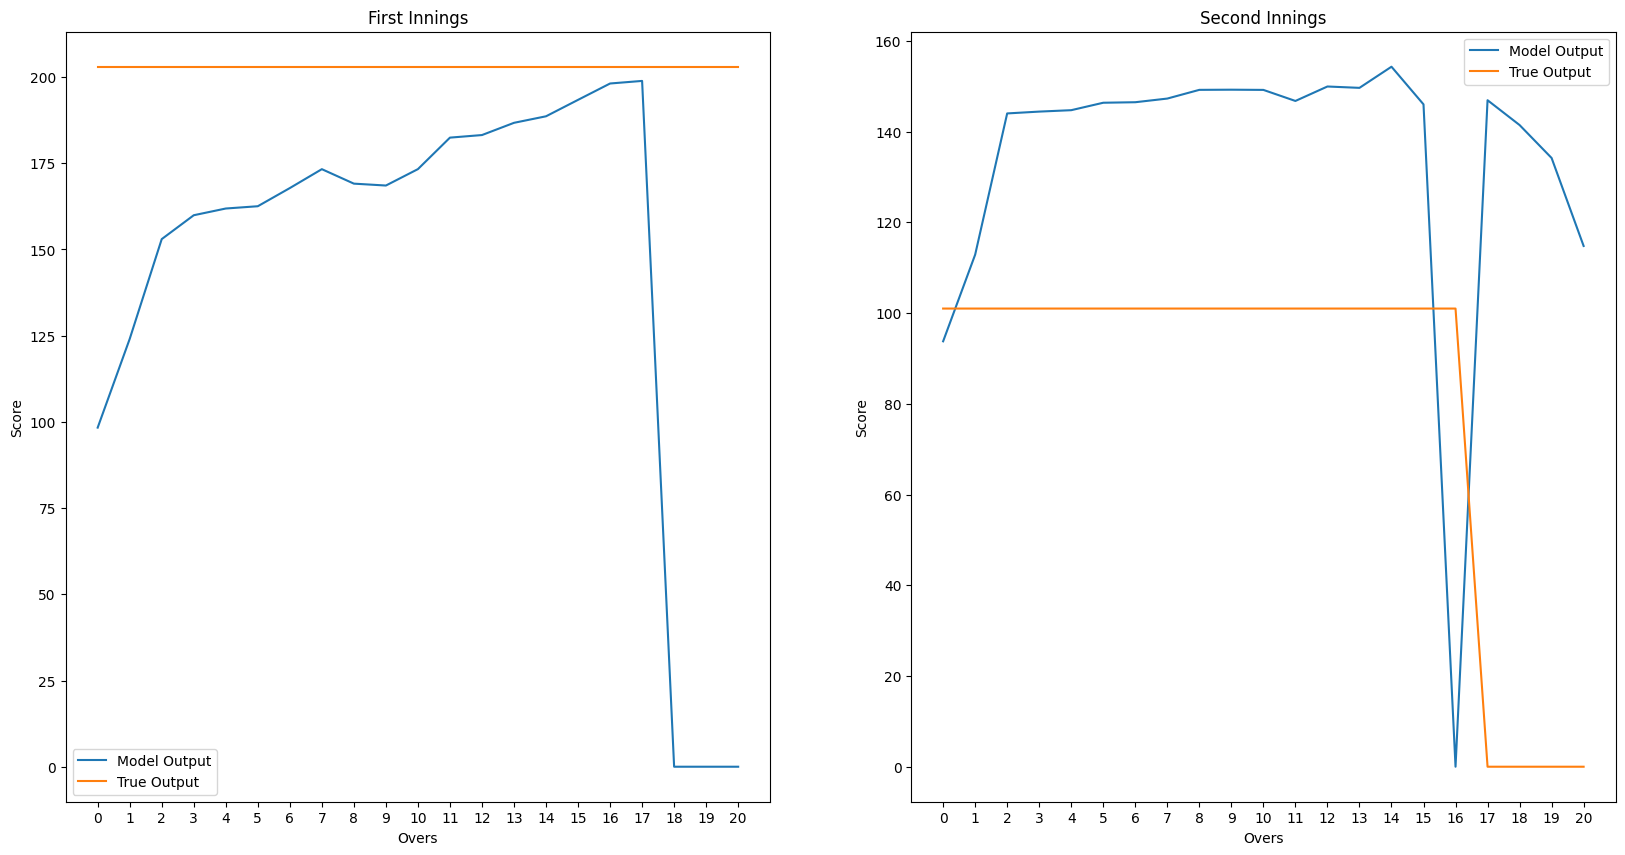

tensor([[ 98.3356, 124.0623, 153.0073, 159.9315, 161.8812, 162.5414, 167.8095,
         173.2908, 169.0932, 168.5461, 173.3036, 182.4381, 183.1843, 186.7313,
         188.6258, 193.3927, 198.1342, 198.8827,   0.0000,   0.0000,   0.0000,
          93.7793, 112.8801, 144.0146, 144.4180, 144.7300, 146.3713, 146.4846,
         147.2916, 149.2117, 149.2468, 149.2021, 146.7642, 149.9512, 149.6521,
         154.3111, 146.0140,   0.0000, 146.9283, 141.4550, 134.1899, 114.7951]],
       device='cuda:0')
tensor([[203., 203., 203., 203., 203., 203., 203., 203., 203., 203., 203., 203.,
         203., 203., 203., 203., 203., 203., 203., 203., 203., 101., 101., 101.,
         101., 101., 101., 101., 101., 101., 101., 101., 101., 101., 101., 101.,
         101., 101.,   0.,   0.,   0.,   0.]], device='cuda:0')


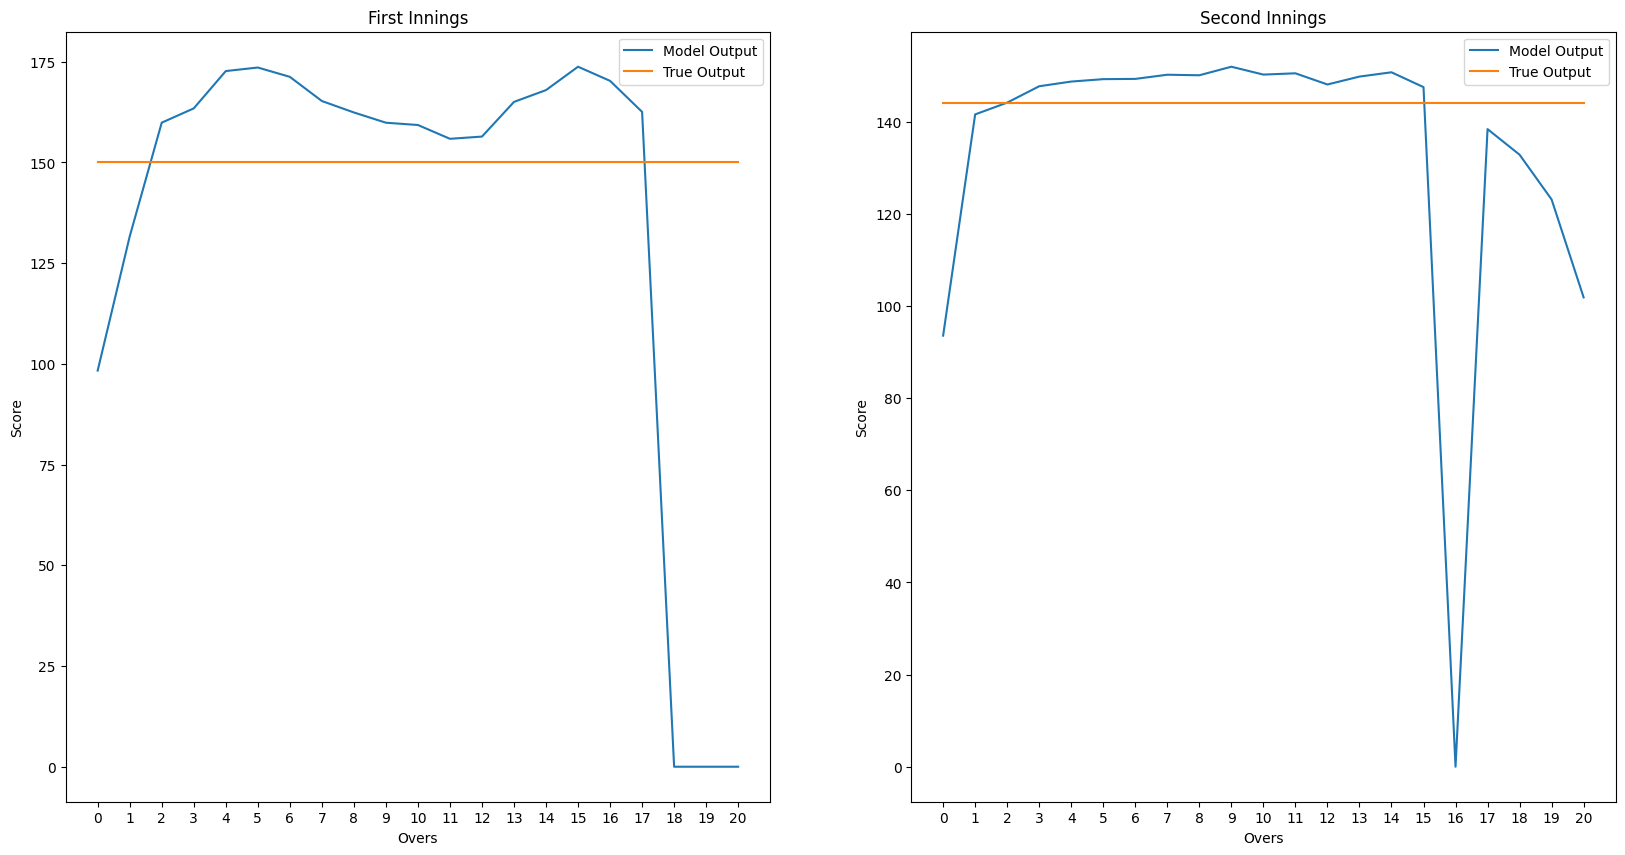

tensor([[ 98.3404, 131.6387, 159.8867, 163.4320, 172.6944, 173.5744, 171.2620,
         165.2590, 162.4189, 159.8754, 159.3025, 155.8788, 156.4309, 165.0435,
         167.9710, 173.7728, 170.2616, 162.5596,   0.0000,   0.0000,   0.0000,
          93.5936, 141.6239, 144.1824, 147.7380, 148.7548, 149.2780, 149.3345,
         150.2382, 150.1210, 151.9766, 150.2679, 150.5469, 148.1203, 149.8367,
         150.7688, 147.5466,   0.0000, 138.4333, 132.8723, 123.1522, 101.8967]],
       device='cuda:0')
tensor([[150., 150., 150., 150., 150., 150., 150., 150., 150., 150., 150., 150.,
         150., 150., 150., 150., 150., 150., 150., 150., 150., 144., 144., 144.,
         144., 144., 144., 144., 144., 144., 144., 144., 144., 144., 144., 144.,
         144., 144., 144., 144., 144., 144.]], device='cuda:0')


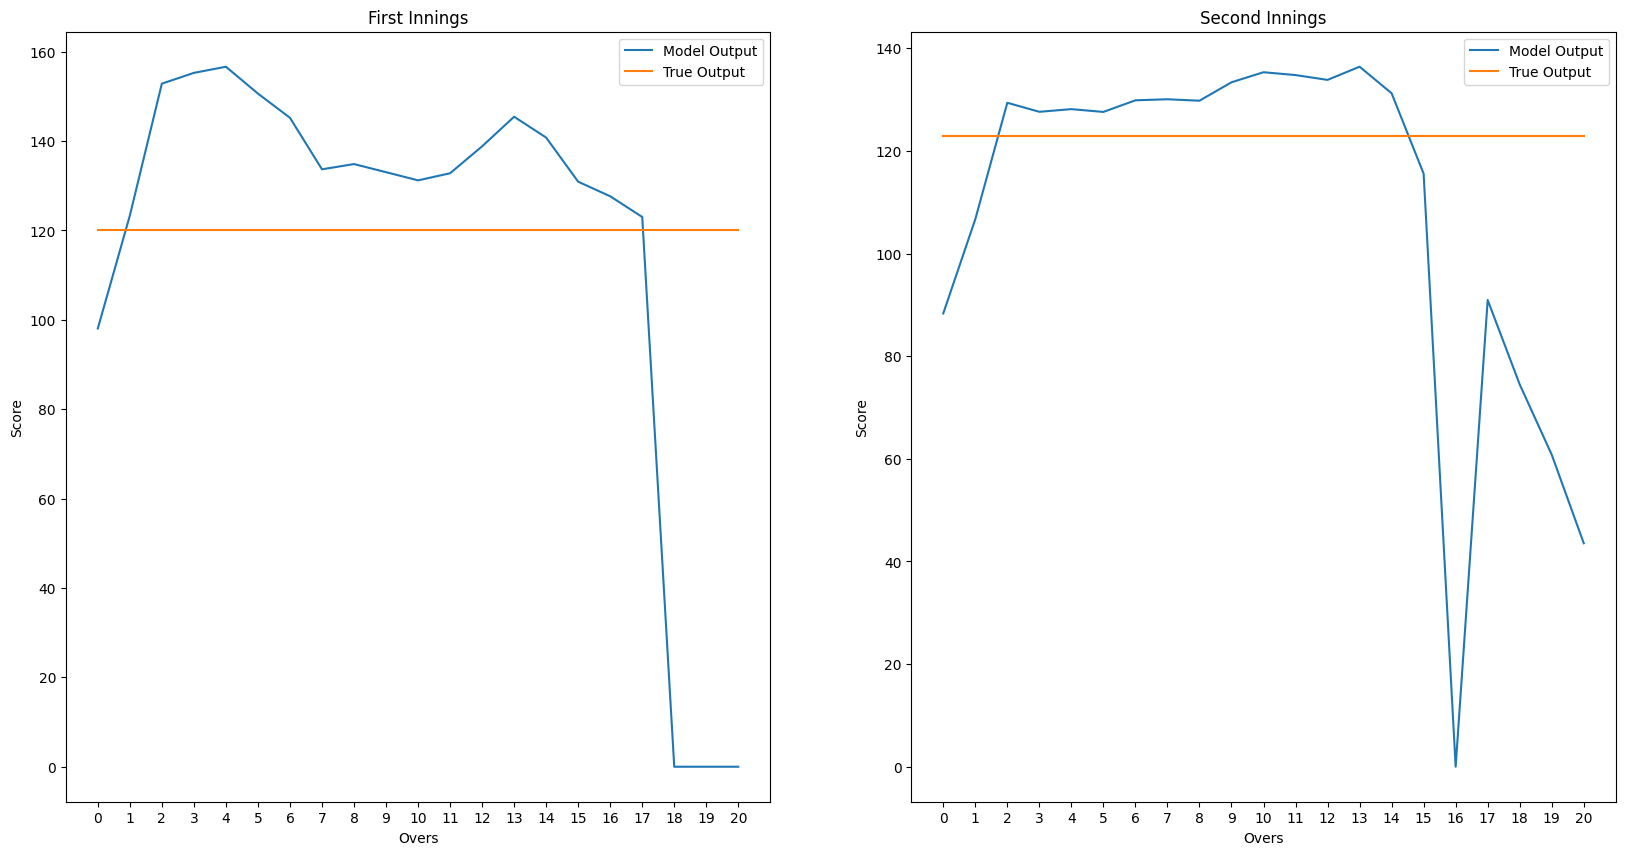

tensor([[ 98.0724, 123.3267, 152.8638, 155.2724, 156.6510, 150.6425, 145.2243,
         133.6926, 134.8677, 133.0516, 131.2197, 132.8097, 138.8358, 145.4601,
         140.7922, 130.9164, 127.6572, 123.0253,   0.0000,   0.0000,   0.0000,
          88.3312, 106.6801, 129.3783, 127.6237, 128.1409, 127.5983, 129.8611,
         130.0656, 129.7826, 133.3728, 135.3324, 134.7788, 133.8416, 136.4064,
         131.2323, 115.5623,   0.0000,  90.9462,  74.4949,  60.8001,  43.5483]],
       device='cuda:0')
tensor([[120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120.,
         120., 120., 120., 120., 120., 120., 120., 120., 120., 123., 123., 123.,
         123., 123., 123., 123., 123., 123., 123., 123., 123., 123., 123., 123.,
         123., 123., 123., 123., 123., 123.]], device='cuda:0')


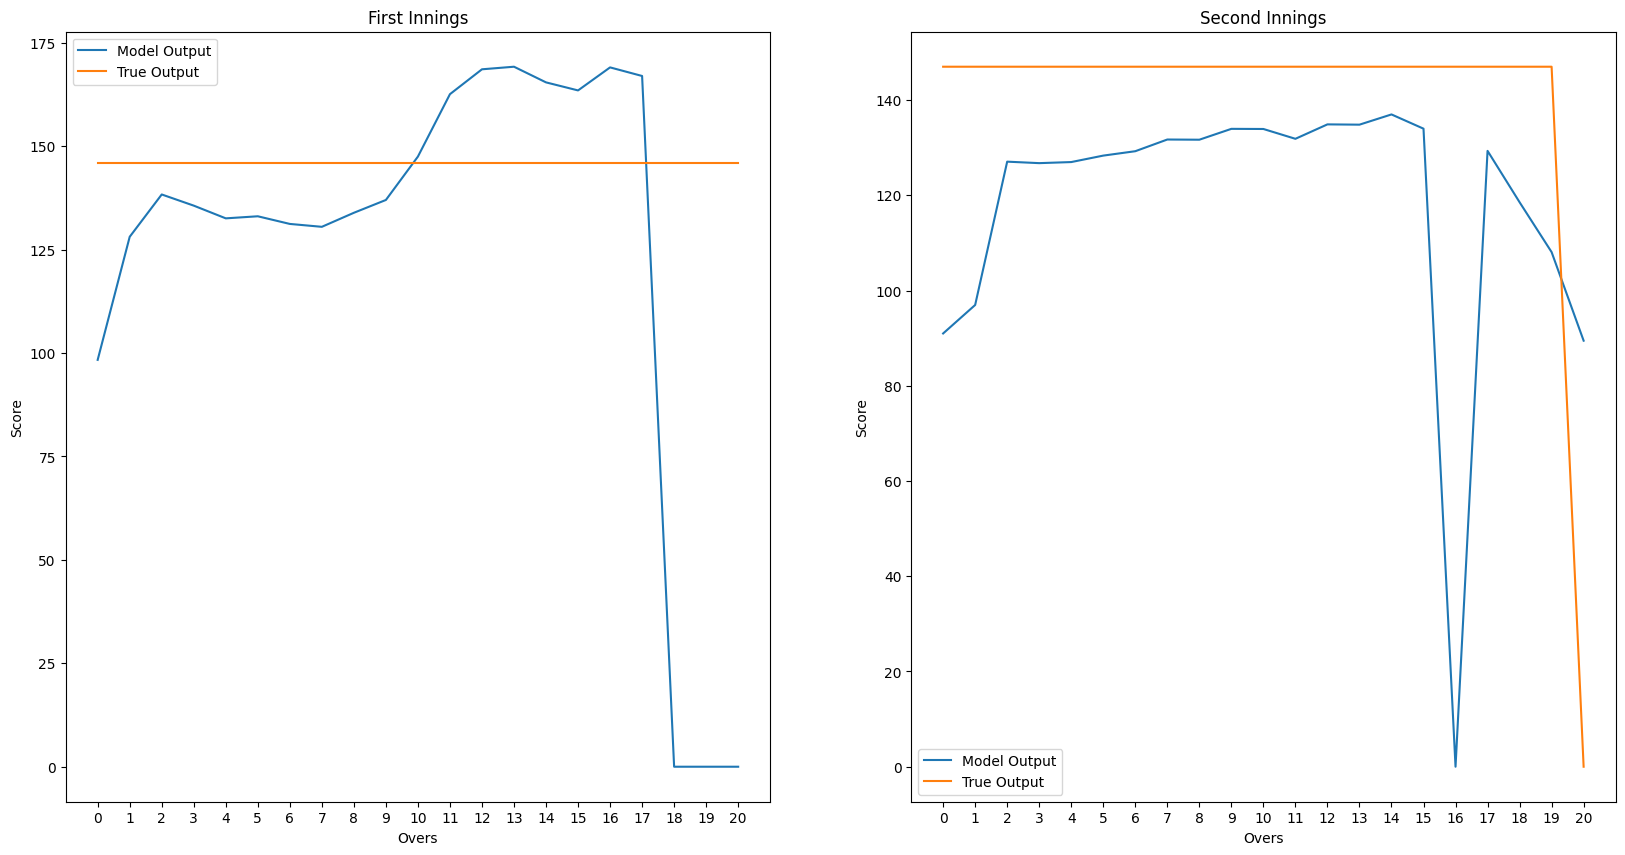

tensor([[ 98.3311, 128.0755, 138.3051, 135.6062, 132.5328, 133.0338, 131.1837,
         130.4861, 133.8777, 136.9773, 147.4685, 162.5467, 168.5562, 169.1792,
         165.3947, 163.4510, 169.0165, 166.9409,   0.0000,   0.0000,   0.0000,
          90.9845,  96.9660, 127.0629, 126.7522, 126.9783, 128.3348, 129.2563,
         131.7124, 131.6718, 133.9526, 133.9254, 131.8623, 134.8920, 134.8326,
         136.9805, 133.9901,   0.0000, 129.3295, 118.5458, 108.0700,  89.4700]],
       device='cuda:0')
tensor([[146., 146., 146., 146., 146., 146., 146., 146., 146., 146., 146., 146.,
         146., 146., 146., 146., 146., 146., 146., 146., 146., 147., 147., 147.,
         147., 147., 147., 147., 147., 147., 147., 147., 147., 147., 147., 147.,
         147., 147., 147., 147., 147.,   0.]], device='cuda:0')


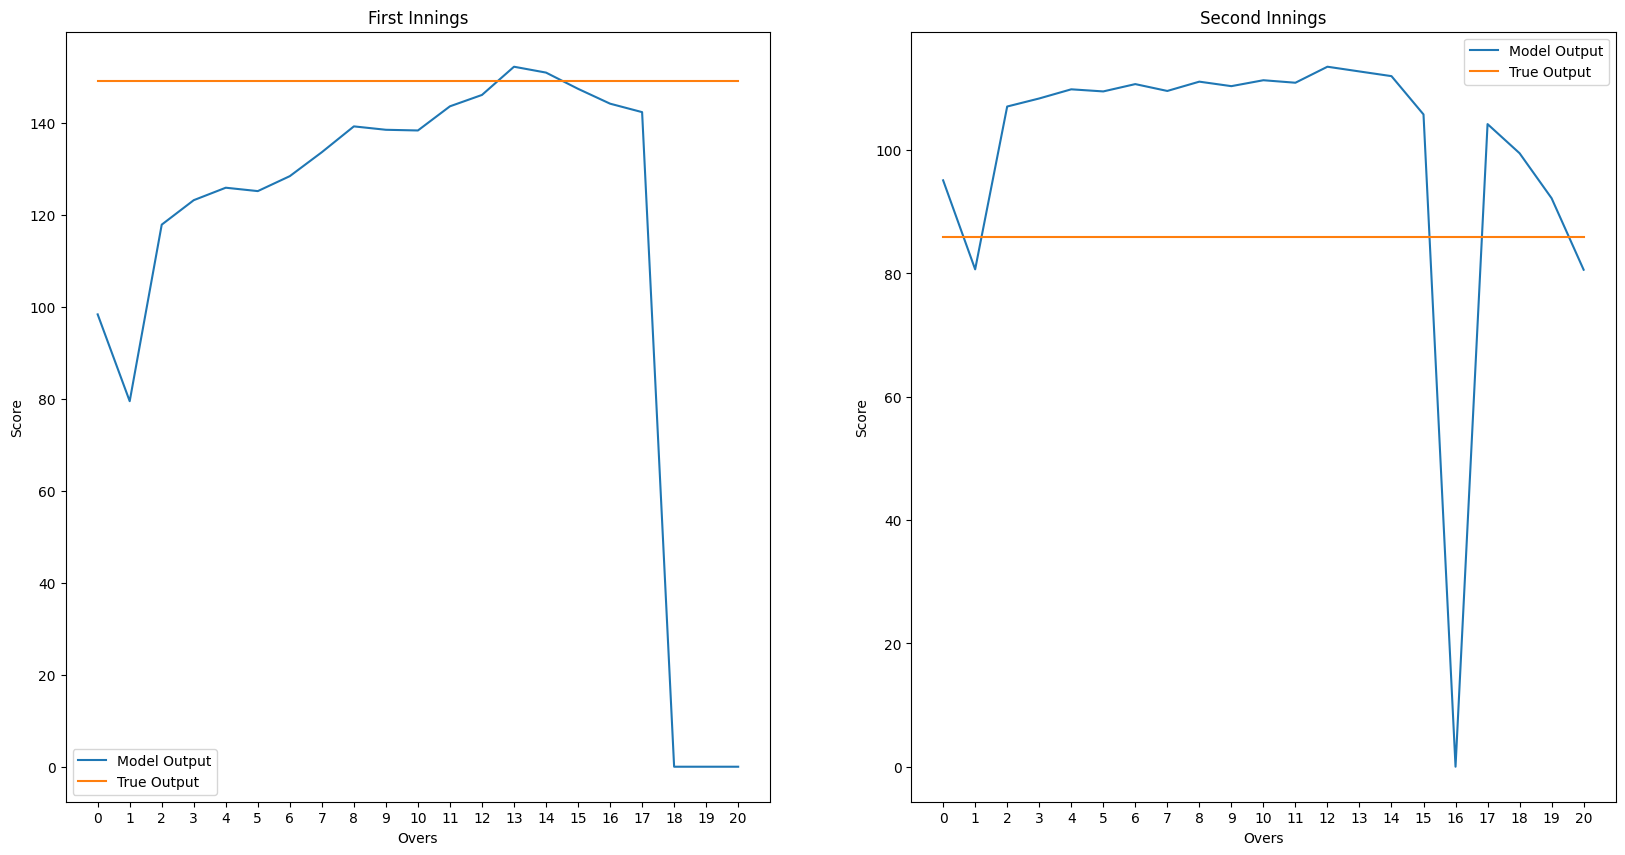

tensor([[ 98.3546,  79.4780, 117.8646, 123.1873, 125.8958, 125.1587, 128.4129,
         133.6197, 139.2316, 138.4923, 138.3423, 143.5958, 146.0679, 152.2034,
         150.9268, 147.3980, 144.1694, 142.3305,   0.0000,   0.0000,   0.0000,
          95.1115,  80.6739, 107.0825, 108.3884, 109.8731, 109.5319, 110.7182,
         109.6075, 111.1152, 110.3865, 111.3459, 110.9409, 113.5378, 112.7709,
         112.0109, 105.8005,   0.0000, 104.2332,  99.5050,  92.2052,  80.6105]],
       device='cuda:0')
tensor([[149., 149., 149., 149., 149., 149., 149., 149., 149., 149., 149., 149.,
         149., 149., 149., 149., 149., 149., 149., 149., 149.,  86.,  86.,  86.,
          86.,  86.,  86.,  86.,  86.,  86.,  86.,  86.,  86.,  86.,  86.,  86.,
          86.,  86.,  86.,  86.,  86.,  86.]], device='cuda:0')


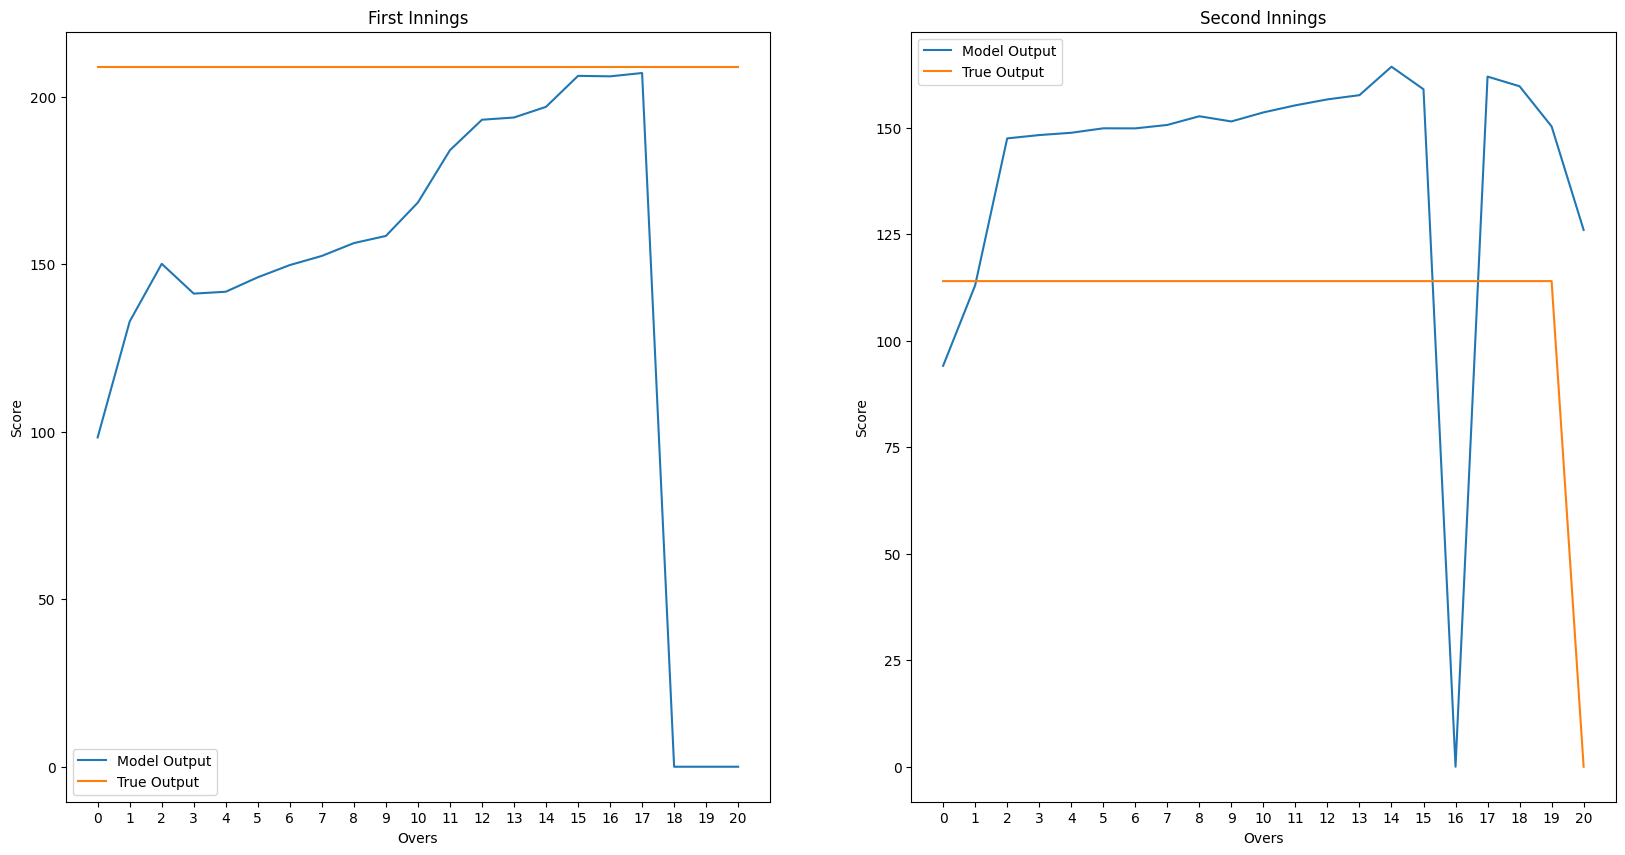

tensor([[ 98.3377, 132.9435, 150.1528, 141.2576, 141.8179, 146.1326, 149.7807,
         152.5102, 156.3395, 158.4789, 168.4663, 184.0783, 193.1736, 193.8381,
         197.0230, 206.2742, 206.1299, 207.1175,   0.0000,   0.0000,   0.0000,
          94.1146, 113.0103, 147.5050, 148.2855, 148.8240, 149.8705, 149.8562,
         150.6622, 152.7034, 151.4806, 153.6019, 155.2664, 156.6606, 157.6555,
         164.3300, 159.0406,   0.0000, 162.0167, 159.7397, 150.3169, 126.0235]],
       device='cuda:0')
tensor([[209., 209., 209., 209., 209., 209., 209., 209., 209., 209., 209., 209.,
         209., 209., 209., 209., 209., 209., 209., 209., 209., 114., 114., 114.,
         114., 114., 114., 114., 114., 114., 114., 114., 114., 114., 114., 114.,
         114., 114., 114., 114., 114.,   0.]], device='cuda:0')


In [38]:
model_score.eval()
with torch.no_grad():
    i = 0
    initial_correct = 0
    sanity_correct = 0

    total = 0
    for x, s, y in test_loader:
        x = x.to(device)
        s = s.to(device)
        y = y.to(device)

        y_mod_1 = torch.zeros(y[:, :, 2].shape[0], y[:, :, 2].shape[1]//2 + 1).to(device)
        y_mod_2 = torch.zeros(y[:, :, 2].shape[0], y[:, :, 2].shape[1]//2 + 1).to(device)

        y_mod_1[:, 1:] = y[:, :20, 2]
        y_mod_1[:, 0] = y[:, 0, 2]

        y_mod_2[:, 1:] = y[:, 20:, 2]
        y_mod_2[:, 0] = y[:, 20, 2]

        # concatenate the two tensors
        y_mod = torch.cat((y_mod_1, y_mod_2), dim=1)


        # Forward pass
        out = model_score(s, x)
        graph_score_trajectory(out.reshape(-1).cpu(), y_mod.reshape(-1).cpu())
        print(out)
        print(y_mod)

        if i == 5:
            break
        i += 1

In [36]:
def graph_score_trajectory(model_output, true_output):
    first_innings_model_output = model_output[:21]
    first_innings_true_output = true_output[:21]

    second_innings_model_output = model_output[21:]
    second_innings_true_output = true_output[21:]

    # show 2 plots in same figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # plot the first innings
    ax1.plot(first_innings_model_output, label='Model Output')
    ax1.plot(first_innings_true_output, label='True Output')
    ax1.set_title('First Innings')
    ax1.set_xlabel('Overs')
    ax1.set_ylabel('Score')
    ax1.legend()

    # plot the second innings
    ax2.plot(second_innings_model_output, label='Model Output')
    ax2.plot(second_innings_true_output, label='True Output')
    ax2.set_title('Second Innings')
    ax2.set_xlabel('Overs')
    ax2.set_ylabel('Score')
    ax2.legend()

    # change x axis ticks
    ax1.set_xticks(np.arange(0, 21, 1))
    ax2.set_xticks(np.arange(0, 21, 1))

    plt.show()



In [39]:
def win_percentage_grapher(model_output, true_output):
    team_2_win_percentage = list(map(lambda x: (x+1)/2 * 100, model_output))
    team_1_win_percentage = list(map(lambda x: 100 - x, team_2_win_percentage))

    plt.figure(figsize=(20, 10))

    # plot the win percentages against overs
    if true_output[0] == 1:
        plt.plot(team_2_win_percentage, label='Team 2 Win Percentage (winner)', color='red')
        plt.plot(team_1_win_percentage, label='Team 1 Win Percentage', color='blue')
    
    else:
        plt.plot(team_1_win_percentage, label='Team 1 Win Percentage (winner)', color='red')
        plt.plot(team_2_win_percentage, label='Team 2 Win Percentage', color='blue')

    plt.title('Win Percentage')
    plt.xlabel('Overs')
    plt.ylabel('Win Percentage')
    plt.legend()
    # x axis ticks
    plt.xticks(np.arange(0, 41, 1))
    # bigger figure
    plt.show()
